In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import trange, tqdm

import geopandas as gpd
from shapely.geometry import Point, Polygon
from osgeo import gdal, osr, ogr

## 预处理

In [2]:
# gdf = gpd.read_file('../../z_GIS_Data/矢量/国界/国家矢量.shp')
url = 'https://geojson.cn/api/data/china.json'
gdf = gpd.read_file(url)
# gdf = gpd.read_file('../../z_GIS_Data/矢量/2023年省级/2023年省级.shp')  # 可以读取 url

<Axes: >

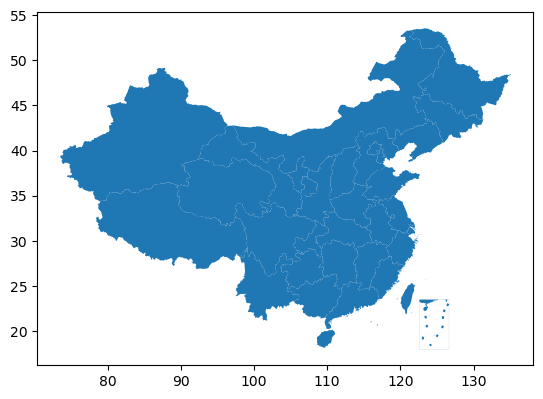

In [3]:
gdf.plot()

In [4]:
def make_grid(boundary, radius):
    # 以边界的中心点按照radius半径进行外扩
    minx, miny, maxx, maxy = boundary.total_bounds
    deltax = ((maxx-minx)%(radius*2)) / 2
    deltay = ((maxy-miny)%(radius*2)) / 2
    minx -= deltax
    maxx += deltax
    miny -= deltay
    maxy += deltay
    cells = []
    for x in np.arange(minx, maxx, radius*2):
        for y in np.arange(miny, maxy, radius*2):
            cells.append(Polygon([(x,y),(x,y+radius*2),(x+radius*2,y+radius*2),(x+radius*2,y),(x,y)]))
    return gpd.GeoDataFrame(cells,columns=['geometry'],crs=boundary.crs).sjoin(boundary,how='inner')  

In [26]:
# gdf1 = gdf[~gdf['name'].isin(['南海诸岛','十段线'])]
# grid = make_grid(gdf1, 0.25)
# grid = grid.reset_index()
# grid['FID'] = grid.index
# grid[['geometry','FID']].to_file('grid.shp')

<Axes: >

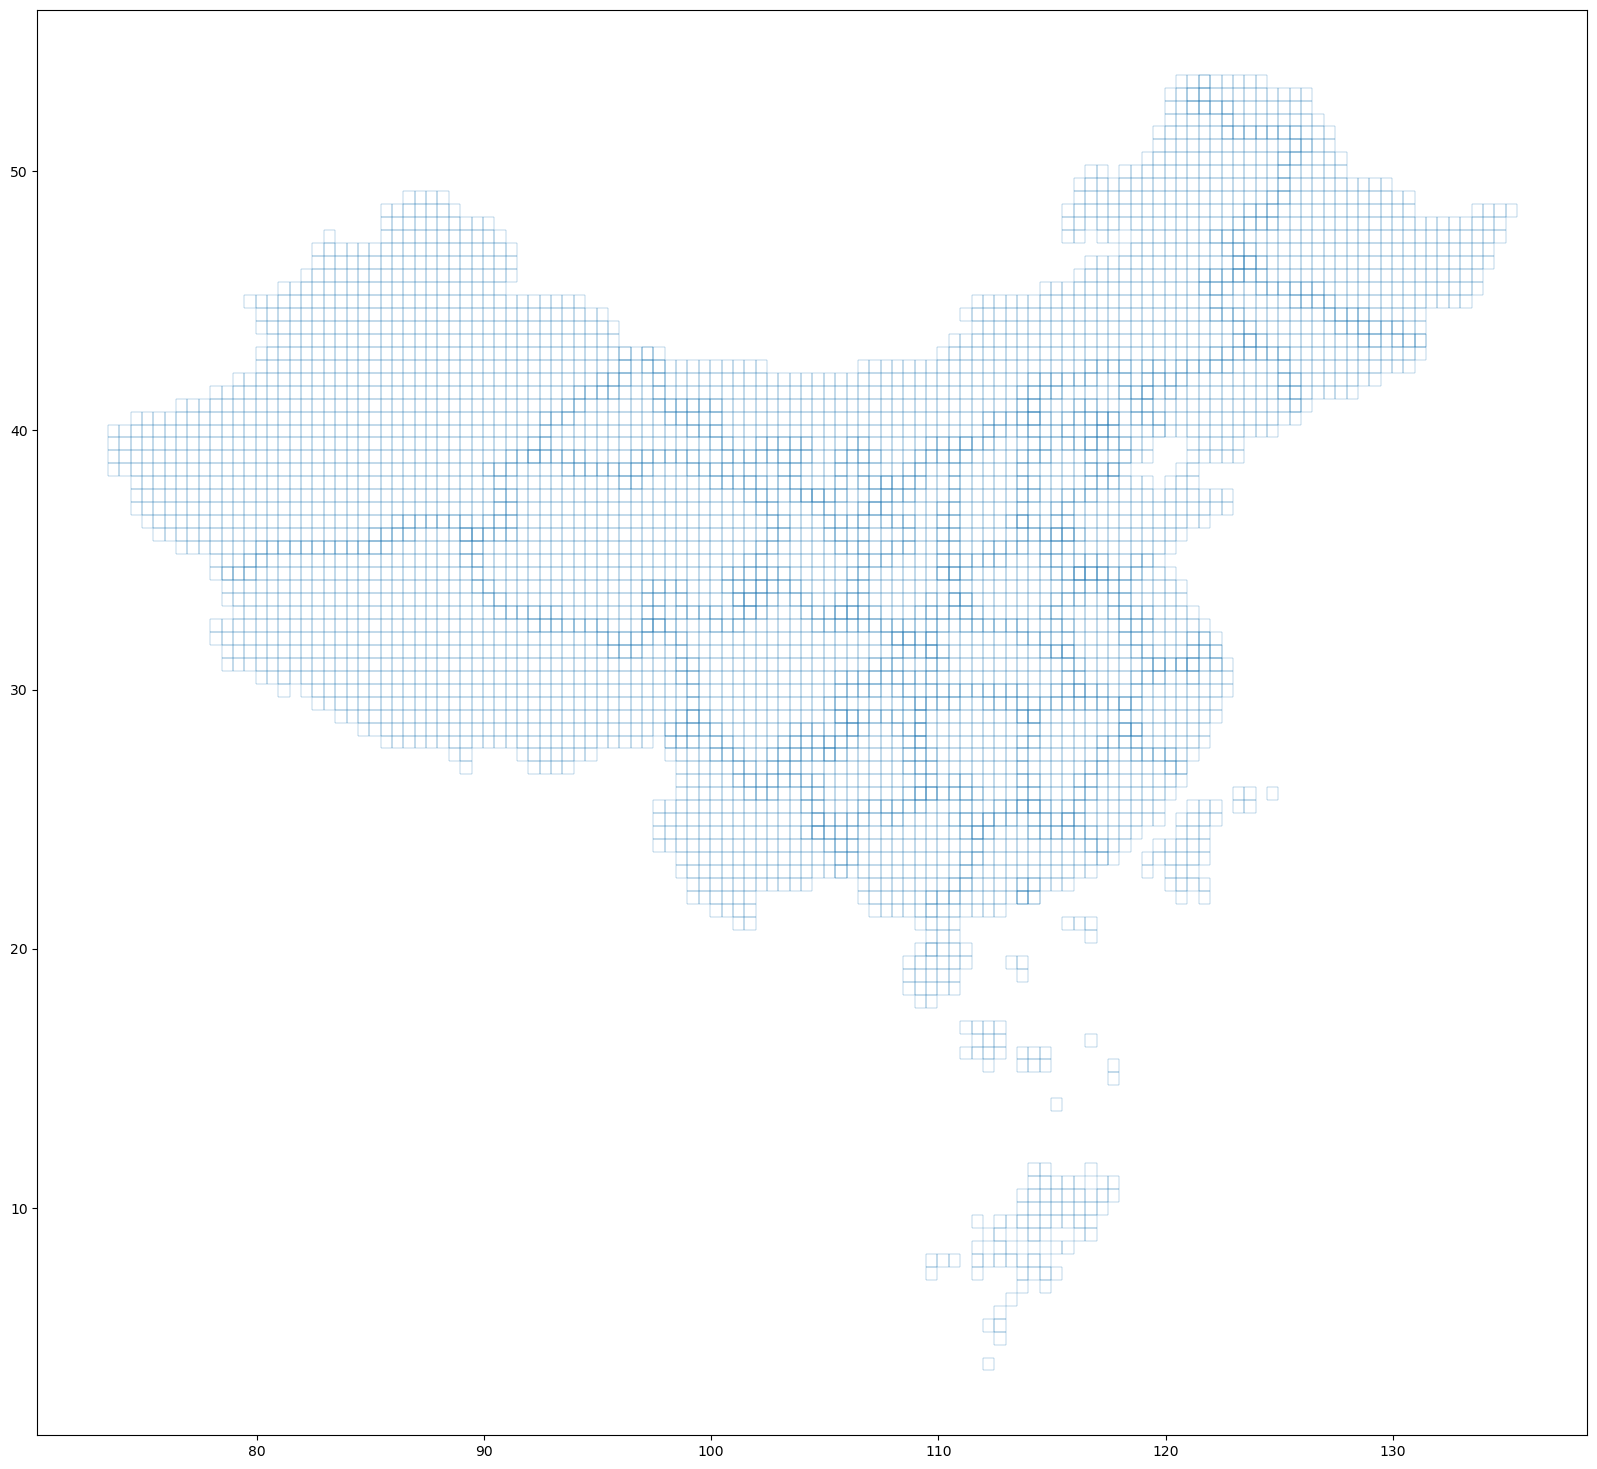

In [6]:
grid.boundary.plot(lw=0.2, figsize=(20,20))

In [7]:
grid.reset_index(inplace=True)
grid = grid[['geometry','ENG_NAME']].copy()
grid['FID'] = grid.index

In [3]:
grid = gpd.read_file('data/矢量/grid.shp')
grid_point = gpd.GeoDataFrame(grid['FID'], geometry=grid.centroid, crs=gdf.crs)

C:\Users\15499\AppData\Local\Temp\ipykernel_23160\2194445403.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid_point = gpd.GeoDataFrame(grid['FID'], geometry=grid.centroid, crs=gdf.crs)


<Axes: >

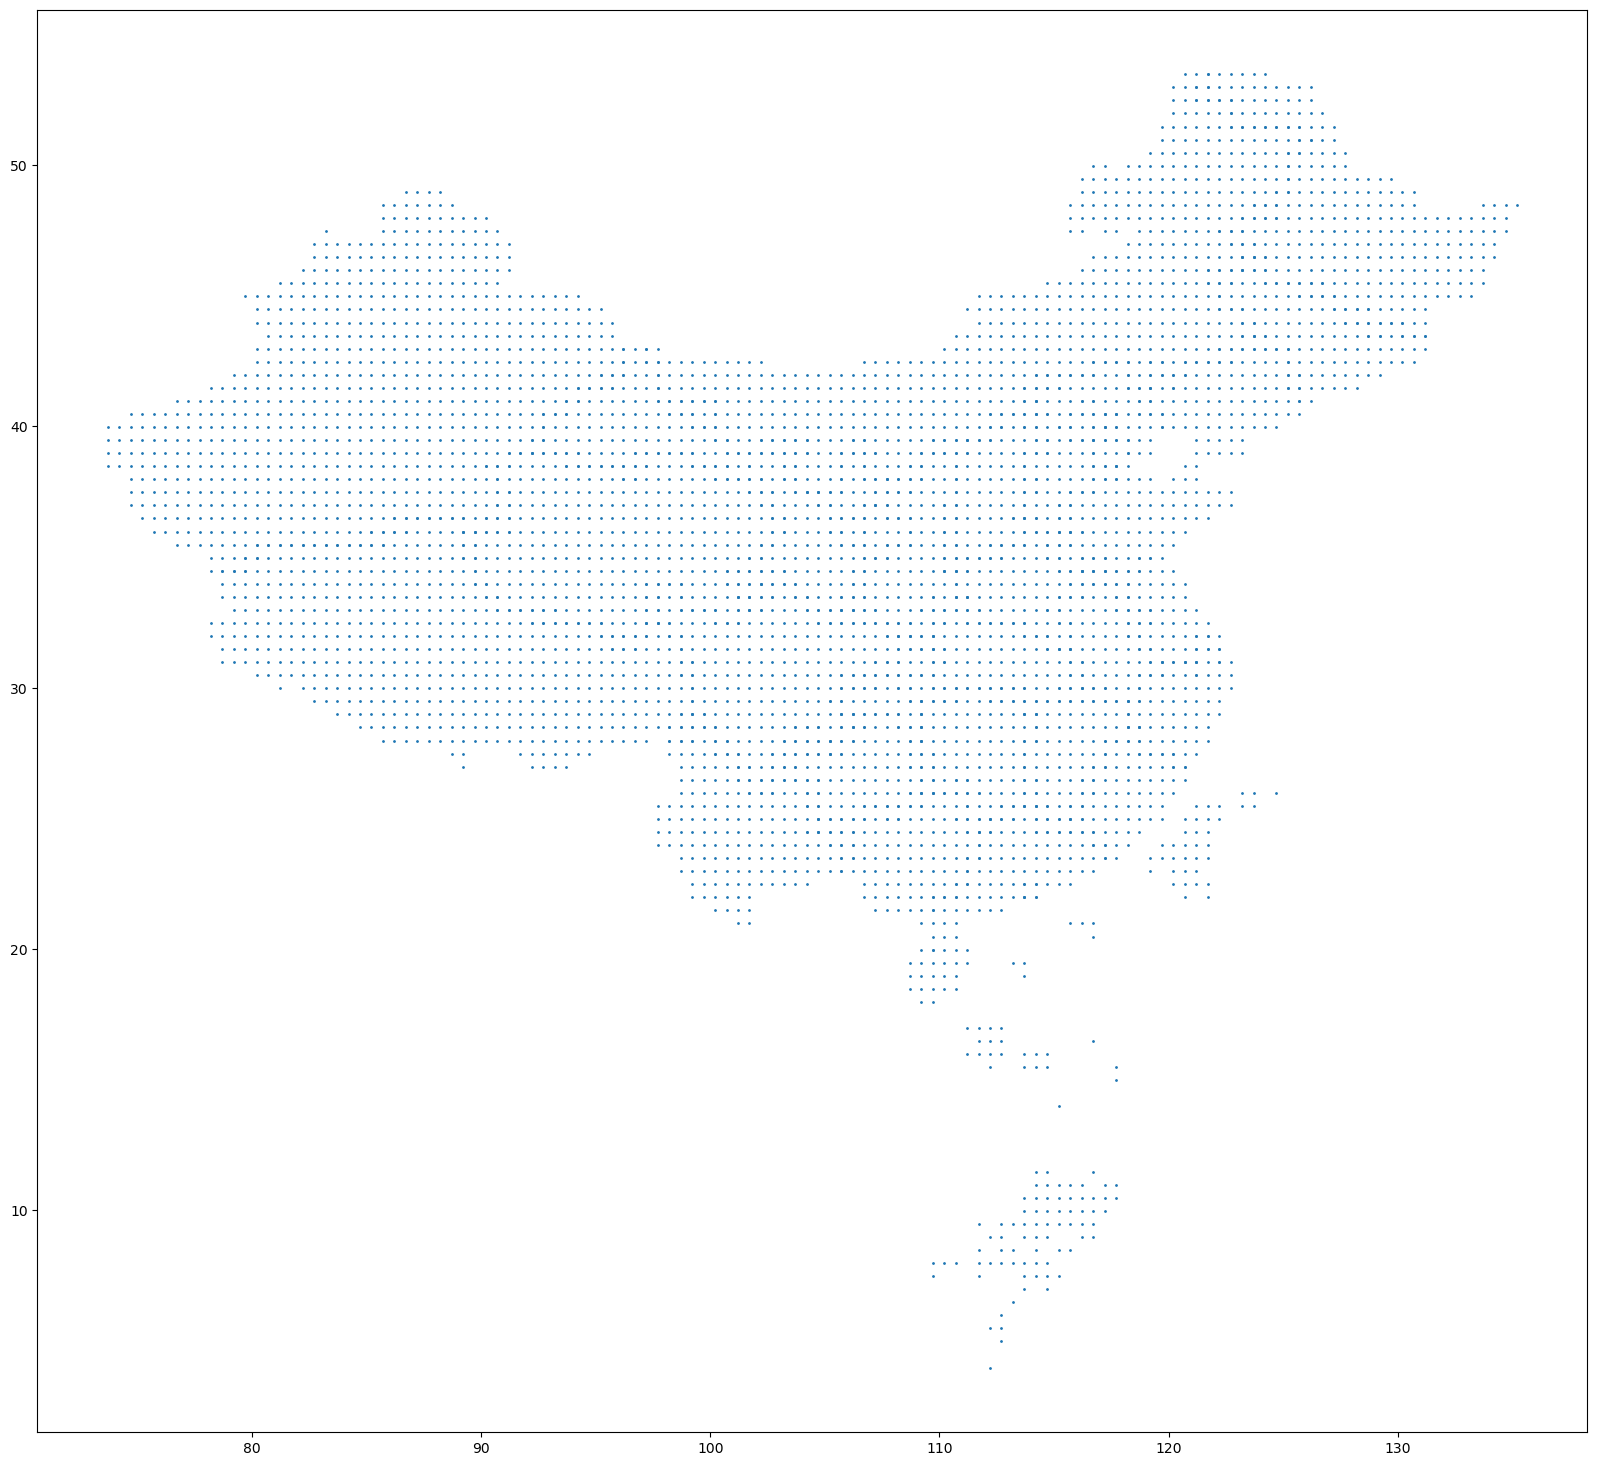

In [5]:
grid_point.plot(markersize=1, figsize=(20,20))

## 提取至点

In [4]:
def get_values(tif_path, name):
    ds = gdal.Open(tif_path)
    if ds is None:
        print('Could not open file')
        return pd.DataFrame()

    # 获取栅格的基本信息
    cols = ds.RasterXSize
    rows = ds.RasterYSize
    
    # 读取整个波段的数据到 numpy 数组中
    band = ds.GetRasterBand(1)
    values = band.ReadAsArray()

    # 将 numpy 数组转换为一维，并创建 DataFrame
    flattened_values = values.flatten()
    
    return pd.DataFrame(data={name: flattened_values})

def get_coordinate(tif_path):
    ds = gdal.Open(tif_path)
    if ds is None:
        print('Could not open file')
        return pd.DataFrame()

    # 获取栅格的基本信息
    cols = ds.RasterXSize
    rows = ds.RasterYSize
    gt = ds.GetGeoTransform()

    # 计算行列号对应的偏移量
    col_indices = np.arange(cols) + 0.5
    row_indices = np.arange(rows) + 0.5

    # 构建网格
    col_grid, row_grid = np.meshgrid(col_indices, row_indices)

    # 计算坐标
    lons = gt[0] + col_grid * gt[1] + row_grid * gt[2]
    lats = gt[3] + col_grid * gt[4] + row_grid * gt[5]

    # 将坐标转换为一维数组
    lon_flattened = lons.flatten()
    lat_flattened = lats.flatten()

    return pd.DataFrame(data={'lon': lon_flattened, 'lat': lat_flattened})

In [5]:
# 所以数据合并起来
# 按年份生成表格
years = [str(year) for year in range(1990,2021)]

### 土地利用数据

In [10]:
path = 'data/中国大陆0.5°土地利用和覆盖变化数据集(1900-2019年)/数据实体/'
landuse = [tif for tif in os.listdir(path) if tif.endswith('tif')]

In [12]:
df_landuse = get_coordinate(path+landuse[0])

In [15]:
# 提取数据
for i in trange(len(landuse)):
    file_name = landuse[i]
    name = file_name.split('.')[0]
    df = get_values(path + file_name, name)
    df_landuse = pd.concat([df_landuse, df], axis=1)

  0%|          | 0/600 [00:00<?, ?it/s]

In [31]:
# gdf1 = gpd.GeoDataFrame(df_landuse[['lon','lat']], geometry=gpd.points_from_xy(df_landuse.lon,df_landuse.lat), crs=gdf.crs)
# gdf1.sjoin(grid)[['lon','lat','FID']].to_csv('data/Q3/landuse_to_index.csv', index=False)

In [47]:
# 计算不透水面
columns = list(set([field.split('-')[1] for field in df_landuse.drop(columns=['lon','lat']).columns]))
for year in columns:
    df_landuse[f'buildup-{year}'] = df_landuse[[field for field in df_landuse.columns if year in field]].sum(axis=1)

C:\Users\15499\AppData\Local\Temp\ipykernel_16880\1664695046.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_landuse[f'buildup-{year}'] = df_landuse[[field for field in df_landuse.columns if year in field]].sum(axis=1)
C:\Users\15499\AppData\Local\Temp\ipykernel_16880\1664695046.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_landuse[f'buildup-{year}'] = df_landuse[[field for field in df_landuse.columns if year in field]].sum(axis=1)
C:\Users\15499\AppData\Local\Temp\ipykernel_16880\1664695046.py:3: PerformanceWarn

In [6]:
grid_point['lon'] = grid_point.centroid.x
grid_point['lat'] = grid_point.centroid.y

C:\Users\15499\AppData\Local\Temp\ipykernel_23160\1865075117.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid_point['lon'] = grid_point.centroid.x
C:\Users\15499\AppData\Local\Temp\ipykernel_23160\1865075117.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid_point['lat'] = grid_point.centroid.y


In [69]:
# 空间连接
gdf1 = gpd.GeoDataFrame(df_landuse[['lon','lat']], geometry=gpd.points_from_xy(df_landuse.lon,df_landuse.lat), crs=gdf.crs)
gdf2 = gdf1.sjoin(grid)

In [72]:
df_landuse1 = df_landuse.merge(gdf2[['lon','lat','FID']], on=['lon','lat'], how='left').dropna()
df_landuse1

,lon,lat,cropland-1900,cropland-1901,cropland-1902,cropland-1903,cropland-1904,cropland-1905,cropland-1906,cropland-1907,...,buildup-1912,buildup-1988,buildup-1954,buildup-1907,buildup-1933,buildup-1930,buildup-1978,buildup-2009,buildup-1974,FID
604,120.475,53.325,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4542.0
605,120.975,53.325,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4604.0
606,121.475,53.325,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4661.0
607,121.475,53.325,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4662.0
608,121.975,53.325,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4713.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10542,109.475,17.825,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2910.0
10799,110.975,16.825,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3125.0
10800,111.475,16.825,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3198.0
10801,111.975,16.825,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3265.0


In [142]:
landuse_grid = df_landuse1.groupby('FID').mean().reset_index()

In [185]:
# 按照年份保存
for year in years:
    columns = [column for column in list(landuse_grid.columns) if year in column] + ['FID']
    landuse_grid[columns].merge(grid_point.drop(columns='geometry'), on='FID', how='left').to_csv(f'data/CSV/土地利用/landuse_{year}.csv', index=False)

### 降水

In [21]:
path = 'data/0.25 Degree Rain(1961-2022)/TIF/'
rain = [tif for tif in os.listdir(path) if tif.endswith('tif')]

In [22]:
df_rain = get_coordinate(path+rain[0])

In [23]:
# 提取数据
for i in trange(len(rain)):
    file_name = rain[i]
    name = file_name.split('.')[0]
    df = get_values(path + file_name, name)
    df_rain = pd.concat([df_rain, df], axis=1)

  0%|          | 0/11322 [00:00<?, ?it/s]

In [74]:
gdf1 = gpd.GeoDataFrame(df_rain[['lon','lat']], geometry=gpd.points_from_xy(df_rain.lon,df_rain.lat), crs=gdf.crs)
gdf2 = gdf1.sjoin(grid)

In [188]:
# sum_ = []
# for year in years:
#     sum_.append(df_rain1[[field for field in list(df_rain1.columns) if year in field]].mean().sum())
# pd.DataFrame(data={'mean':sum_,'year':years}).to_csv('mean.csv', index=False)

In [75]:
df_rain1 = df_rain.merge(gdf2[['lon','lat','FID']], on=['lon','lat'], how='left').dropna()
df_rain1

,lon,lat,1990-01-01,1990-01-02,1990-01-03,1990-01-04,1990-01-05,1990-01-06,1990-01-07,1990-01-08,...,2020-12-22,2020-12-23,2020-12-24,2020-12-25,2020-12-26,2020-12-27,2020-12-28,2020-12-29,2020-12-30,FID
145,108.50,18.25,-99.900002,-99.900002,-99.900002,-99.900002,-99.900002,-99.900002,-99.900002,-99.900002,...,-99.900002,-99.900002,-99.900002,-99.900002,-99.900002,-99.900002,-99.900002,-99.900002,-99.900002,2773.0
146,108.75,18.25,-99.900002,-99.900002,-99.900002,-99.900002,-99.900002,-99.900002,-99.900002,-99.900002,...,-99.900002,-99.900002,-99.900002,-99.900002,-99.900002,-99.900002,-99.900002,-99.900002,-99.900002,2773.0
147,109.00,18.25,-99.900002,-99.900002,-99.900002,-99.900002,-99.900002,-99.900002,-99.900002,-99.900002,...,-99.900002,-99.900002,-99.900002,-99.900002,-99.900002,-99.900002,-99.900002,-99.900002,-99.900002,2839.0
148,109.25,18.25,0.100000,1.720000,0.450000,0.760000,0.230000,0.420000,0.180000,0.000000,...,0.000000,0.220000,0.060000,0.000000,0.000000,0.090000,0.000000,0.000000,0.020000,2839.0
149,109.50,18.25,0.050000,1.040000,0.310000,0.600000,0.130000,0.200000,0.090000,0.000000,...,0.000000,0.130000,0.030000,0.000000,0.000000,0.070000,0.000000,0.000000,0.010000,2911.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40072,123.25,53.50,0.000000,0.000000,0.000000,0.710000,0.360000,0.000000,0.000000,0.500000,...,0.140000,0.100000,0.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,4802.0
40073,123.50,53.50,0.000000,0.000000,0.000000,0.650000,0.420000,0.000000,0.000000,0.470000,...,0.160000,0.150000,0.000000,0.030000,0.000000,0.000000,0.000000,0.000000,0.000000,4843.0
40074,123.75,53.50,0.000000,0.000000,0.000000,0.520000,0.500000,0.000000,0.000000,0.390000,...,0.170000,0.210000,0.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,4843.0
40075,124.00,53.50,0.000000,0.000000,0.000000,0.450000,0.560000,0.000000,0.000000,0.330000,...,0.180000,0.270000,0.000000,0.060000,0.000000,0.000000,0.000000,0.000000,0.000000,4879.0


In [84]:
# 过滤研究区外的异常值
df_rain1 = df_rain1[~(df_rain1 < 0).any(axis=1)]
df_rain1

,lon,lat,1990-01-01,1990-01-02,1990-01-03,1990-01-04,1990-01-05,1990-01-06,1990-01-07,1990-01-08,...,2020-12-22,2020-12-23,2020-12-24,2020-12-25,2020-12-26,2020-12-27,2020-12-28,2020-12-29,2020-12-30,FID
148,109.25,18.25,0.10,1.72,0.45,0.76,0.23,0.42,0.18,0.00,...,0.00,0.22,0.06,0.00,0.0,0.09,0.0,0.0,0.02,2839.0
149,109.50,18.25,0.05,1.04,0.31,0.60,0.13,0.20,0.09,0.00,...,0.00,0.13,0.03,0.00,0.0,0.07,0.0,0.0,0.01,2911.0
150,109.75,18.25,0.01,0.45,0.17,0.42,0.05,0.06,0.03,0.00,...,0.00,0.05,0.01,0.00,0.0,0.04,0.0,0.0,0.00,2911.0
403,109.00,18.50,0.15,2.27,0.44,0.78,0.28,0.68,0.26,0.00,...,0.00,0.23,0.06,0.00,0.0,0.08,0.0,0.0,0.02,2839.0
404,109.25,18.50,0.11,2.61,0.42,0.86,0.78,0.65,0.21,0.00,...,0.00,0.19,0.06,0.00,0.0,0.07,0.0,0.0,0.02,2839.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40072,123.25,53.50,0.00,0.00,0.00,0.71,0.36,0.00,0.00,0.50,...,0.14,0.10,0.00,0.02,0.0,0.00,0.0,0.0,0.00,4802.0
40073,123.50,53.50,0.00,0.00,0.00,0.65,0.42,0.00,0.00,0.47,...,0.16,0.15,0.00,0.03,0.0,0.00,0.0,0.0,0.00,4843.0
40074,123.75,53.50,0.00,0.00,0.00,0.52,0.50,0.00,0.00,0.39,...,0.17,0.21,0.00,0.05,0.0,0.00,0.0,0.0,0.00,4843.0
40075,124.00,53.50,0.00,0.00,0.00,0.45,0.56,0.00,0.00,0.33,...,0.18,0.27,0.00,0.06,0.0,0.00,0.0,0.0,0.00,4879.0


In [139]:
rain_grid = df_rain1.groupby('FID').mean().reset_index()

In [184]:
# 按照年份保存
for year in years:
    columns = [column for column in list(rain_grid.columns) if year in column] + ['FID']
    rain_grid[columns].merge(grid_point.drop(columns='geometry'), on='FID', how='left').to_csv(f'data/CSV/降雨/rain_{year}.csv', index=False)

### 温度

- 温度数据是两层文件夹

In [127]:
path = 'data/气温数据集/日平均数据/'
dir_next = [file for file in os.listdir(path) if file.split('_')[0] in years]

In [128]:
temperature = []
for file in dir_next:
    temperature += [path + file + '/' + tif for tif in os.listdir(path + file) if tif.endswith('.tif')]

In [195]:
df_temperature = get_coordinate(tifs[0])
gdf1 = gpd.GeoDataFrame(df_temperature[['lon','lat']], geometry=gpd.points_from_xy(df_temperature.lon,df_temperature.lat), crs=gdf.crs)
gdf2 = gdf1.sjoin(grid)
gdf2

,lon,lat,geometry,index_right,ENG_NAME,FID
9605,120.550004,53.650763,POINT (120.55000 53.65076),4542,Neimenggu,4542
9606,120.650004,53.650763,POINT (120.65000 53.65076),4542,Neimenggu,4542
9607,120.750004,53.650763,POINT (120.75000 53.65076),4542,Neimenggu,4542
9608,120.850004,53.650763,POINT (120.85000 53.65076),4542,Neimenggu,4542
9609,120.950004,53.650763,POINT (120.95000 53.65076),4542,Neimenggu,4542
...,...,...,...,...,...,...
279775,117.550004,15.050763,POINT (117.55000 15.05076),4091,Hainan,4091
279776,117.650004,15.050763,POINT (117.65000 15.05076),4091,Hainan,4091
279777,117.750004,15.050763,POINT (117.75000 15.05076),4091,Hainan,4091
279778,117.850004,15.050763,POINT (117.85000 15.05076),4091,Hainan,4091


In [187]:
for i in trange(len(temperature)):
    file = temperature[i]
    name = file.split('/')[-1][:8]
    df = get_values(file, name)
    df.to_csv(f'data/CSV/中间数据集/{name}.csv', index=False)
    # df_temperature = pd.concat([df_temperature, df], axis=1)

  0%|          | 0/10592 [00:00<?, ?it/s]

In [211]:
path = 'data/CSV/中间数据集/'
csvs = os.listdir(path)
for i in trange(len(years)):
    df_all = pd.DataFrame()
    year = years[i]
    csv_ = [csv for csv in csvs if csv.startswith(year)]
    if csv_:
        for csv in csv_:
            df = pd.read_csv(path + csv)
            df_all = pd.concat([df_all, df], axis=1)
    df_all = pd.concat([df_all, df_temperature], axis=1)
    df_all.merge(gdf2[['lon','lat','FID']], on=['lon','lat'], how='left').dropna().to_csv(f'data/CSV/温度/temperature_{year}.csv', index=False)

  0%|          | 0/31 [00:00<?, ?it/s]

### GDP

In [9]:
# 坐标转换
def reproject_to_wgs84(input_tif, output_tif):
    dataset = gdal.Open(input_tif)
    if dataset is None:
        raise FileNotFoundError(f"无法打开文件: {input_tif}")
    
    proj = dataset.GetProjection()  # 获取输入图像的投影信息
    
    # 创建目标坐标系
    target_srs = osr.SpatialReference()
    target_srs.ImportFromEPSG(4326)  # EPSG:4326为WGS84
    
    # 始坐标系
    source_srs = osr.SpatialReference()
    source_srs.ImportFromWkt(proj)
    
    # 创建坐标转换对象
    coord_transform = osr.CoordinateTransformation(source_srs, target_srs)
    gdal.Warp(output_tif, dataset, dstSRS='EPSG:4326')

def select_df(df, lon_col, lat_col, gdf):
    polygon = gdf.unary_union  # 获取整个gdf的多边形范围
    points = [Point(lon, lat) for lon, lat in zip(df[lon_col], df[lat_col])]  # 将lon和lat转换为点的列表
    mask = [polygon.contains(point) for point in points]  # 使用向量化的contains方法来检查点是否位于shp多边形内
    df_in_shape = df[mask]   # 筛选出位于gdf边界内的点

    return df_in_shape

# 提取坐标和值
def get_values_(input_tif, name):
    ds = gdal.Open(input_tif)
    if ds is None:
        print('Could not open file')
        return pd.DataFrame()
    
    # 读取整个波段的数据到numpy数组中
    band = ds.GetRasterBand(1)
    values = band.ReadAsArray()

    flattened_values = values.flatten()  # 将numpy数组转换为一维，并创建DataFrame

    # 获取栅格的基本信息
    cols = ds.RasterXSize
    rows = ds.RasterYSize
    gt = ds.GetGeoTransform()

    # 计算行列号对应的偏移量
    col_indices = np.arange(cols) + 0.5
    row_indices = np.arange(rows) + 0.5

    col_grid, row_grid = np.meshgrid(col_indices, row_indices)  # 构建网格

    # 计算坐标
    lons = gt[0] + col_grid * gt[1] + row_grid * gt[2]
    lats = gt[3] + col_grid * gt[4] + row_grid * gt[5]

    # 将坐标转换为一维数组
    lon_flattened = lons.flatten()
    lat_flattened = lats.flatten()

    return pd.DataFrame(data={'lon':lon_flattened,'lat':lat_flattened,name:flattened_values})

def clip_tif(input_tif, shapefile, output_tif, nodata_value=-999):
    src_ds = gdal.Open(input_tif)
    # 使用gdal.Warp进行裁剪并设置NoData
    gdal.Warp(
        output_tif,           # 输出文件
        src_ds,               # 输入栅格数据集
        format="GTiff",       # 输出格式
        cutlineDSName=shapefile,  # 矢量文件路径
        cropToCutline=True,   # 仅裁剪到矢量边界
        dstNodata=nodata_value,  # 设置掩膜区域外的NoData值
        warpOptions=["CUTLINE_ALL_TOUCHED=TRUE"]  # 确保裁剪时考虑所有被触及的像素
    )

In [9]:
path = 'data/GDP数据集/GDP_output/'
new_proj_path = 'data/CSV/中间数据集/'
shp_file = '../../z_GIS_Data/矢量/2023年省级/2023年省级.shp'

gdp = [tif for tif in os.listdir(path) if tif.endswith('tif')]

In [28]:
# 统一为 wgs84
for i in trange(len(gdp)):
    file_name = gdp[i]
    reproject_to_wgs84(path+file_name, new_proj_path+file_name)

  0%|          | 0/26 [00:00<?, ?it/s]

In [18]:
# 裁剪
for i in trange(len(gdp)):
    file_name = gdp[i]
    clip_tif(new_proj_path+file_name, shp_file, new_proj_path+'clip_'+file_name)

  0%|          | 0/26 [00:00<?, ?it/s]

In [36]:
# 直接求格网均值
gdp_ = [tif for tif in os.listdir(new_proj_path) if tif.startswith('clip')]
for i in trange(len(gdp_)):
    file_name = gdp_[i]
    name = file_name.split('.')[0].split('_')[1]
    df = get_values_(new_proj_path + file_name, name)
    df_gdp = gpd.GeoDataFrame(df[['lon','lat',name]], geometry=gpd.points_from_xy(df.lon,df.lat), crs=gdf.crs).sjoin(grid[['geometry','FID']]).drop(columns=['geometry','index_right','lon','lat'])  # 确定研究区内的数据
    df_gdp = df_gdp[df_gdp[name]>=0].copy()  # 过滤NoData
    df_gdp.groupby('FID').mean().reset_index().to_csv(f'data/CSV/GDP/{name}.csv', index=False)  # 求均值然后保存

  0%|          | 0/26 [00:00<?, ?it/s]

### DEM相关

In [10]:
path = 'data/中国数字高程图(1km)/Albers_105/TIFF/'
new_proj_path = 'data/CSV/中间数据集/'
shp_file = '../../z_GIS_Data/矢量/2023年省级/2023年省级.shp'

dem = [tif for tif in os.listdir(path) if tif.endswith('tif')]

In [39]:
# 统一为 wgs84
for i in trange(len(dem)):
    file_name = dem[i]
    reproject_to_wgs84(path+file_name, new_proj_path+file_name)

  0%|          | 0/4 [00:00<?, ?it/s]

In [44]:
# 裁剪
for i in trange(len(dem)):
    file_name = dem[i]
    clip_tif(new_proj_path+file_name, shp_file, new_proj_path+'clip_'+file_name)

  0%|          | 0/4 [00:00<?, ?it/s]

In [16]:
# 提取
dem_ = [tif for tif in os.listdir(new_proj_path) if tif.startswith('clip')]
for i in trange(len(dem_)):
    file_name = dem_[i]
    name = file_name.split('.')[0][5:]
    df = get_values_(new_proj_path+file_name, name)
    df_dem = gpd.GeoDataFrame(df[['lon','lat',name]], geometry=gpd.points_from_xy(df.lon,df.lat), crs=gdf.crs).sjoin(grid[['geometry','FID']]).drop(columns=['geometry','index_right','lon','lat']) 
    df_dem = df_dem[df_dem[name]>=0].copy()
    df_dem.groupby('FID').mean().reset_index().to_csv(f'data/CSV/DEM/{name}.csv', index=False)  # 求均值然后保存

  0%|          | 0/4 [00:00<?, ?it/s]

### 人口

In [16]:
path = 'data/人口数据集/pop_output/'
new_proj_path = 'data/CSV/中间数据集/'
shp_file = '../../z_GIS_Data/矢量/2023年省级/2023年省级.shp'

dir_next = os.listdir(path)

In [13]:
# 坐标统一wgs84
for i in trange(len(dir_next)):
    file_name = [tif for tif in os.listdir(path+dir_next[i]) if tif.endswith('tif')][0]
    reproject_to_wgs84(path+dir_next[i]+'/'+file_name, new_proj_path+file_name)

  0%|          | 0/26 [00:00<?, ?it/s]

In [17]:
# 裁剪
pop = [tif for tif in os.listdir(new_proj_path) if tif.endswith('.tif')]
for i in trange(len(pop)):
    file_name = pop[i]
    clip_tif(new_proj_path+file_name, shp_file, new_proj_path+'clip_'+file_name)

  0%|          | 0/26 [00:00<?, ?it/s]

In [20]:
# 提取
pop_ = [tif for tif in os.listdir(new_proj_path) if tif.startswith('clip')]
for i in trange(len(pop_)):
    file_name = pop_[i]
    name = file_name.split('.')[0][5:]
    df = get_values_(new_proj_path+file_name, name)
    df_dem = gpd.GeoDataFrame(df[['lon','lat',name]], geometry=gpd.points_from_xy(df.lon,df.lat), crs=gdf.crs).sjoin(grid[['geometry','FID']]).drop(columns=['geometry','index_right','lon','lat']) 
    df_dem = df_dem[df_dem[name]>=0].copy()
    df_dem.groupby('FID').mean().reset_index().to_csv(f'data/CSV/人口/{name}.csv', index=False)  # 求均值然后保存

  0%|          | 0/26 [00:00<?, ?it/s]